Please copy the notebook and fill. Once filled, upload it to the course Brightspace.

---
If you worked with other students, provide name(s) here: Ted helped a lot with the convolutional dimension sizes, Camryn with the final block for appending the true prediction. 

# ECG Anomaly Detection with Autoencoders

This homework will consists of a guided notebook where you will have to fill-in some blanks and comment. The notebook explores how we can detect abnormal electrocardiograms (ECG) with deep learning. It is likely not the most performant or best approach, but it will show the main concepts. You do not have to obtain a very performant model.



### Data
The dataset contains samples of 5,000 ECG with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure. If you are not familiar with ECG, you may read up a bit on it, e.g. on [wikipedia](https://en.wikipedia.org/wiki/Electrocardiography).


Here the dataset has simply been labelled with two classes: normal and abnormal.
We will use the labels to split the dataset.

Let us start with boiler plate code.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data preparation

The original data can be found on PhysioNet and is described [here](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). It was all prepared to be one single CSV file and can be found on [tensorflow tutorial](https://www.tensorflow.org/tutorials/generative/autoencoder#third_example_anomaly_detection).
We follow the same pre-processing steps and some of the evaluation procedures, with the slight differences, and with PyTorch.



In [2]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the ECG data
data = raw_data[:, 0:-1]

n_features = data.shape[1]

# split full data into training and test set
xtrain_data, test_data, ytrain_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21)

#  split a validation set from the training set
train_data, val_data, train_labels, val_labels = train_test_split(
    xtrain_data, ytrain_labels, test_size=0.2, random_state=22)


print(train_data.shape, val_data.shape, test_data.shape)

(3198, 140) (800, 140) (1000, 140)


The data are numpy arrays. Use scikit-learn `MinMaxScaling` to scale appropriately the training, validation and test sets.

In [3]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data.copy())
val_data = scaler.transform(val_data.copy())
test_data = scaler.transform(test_data.copy())

train_labels = train_labels.astype(bool)
val_labels = val_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_val_data = val_data[val_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_val_data = val_data[~val_labels]
anomalous_test_data = test_data[~test_labels]

Plot a few samples or normal and abnormal ECGs.

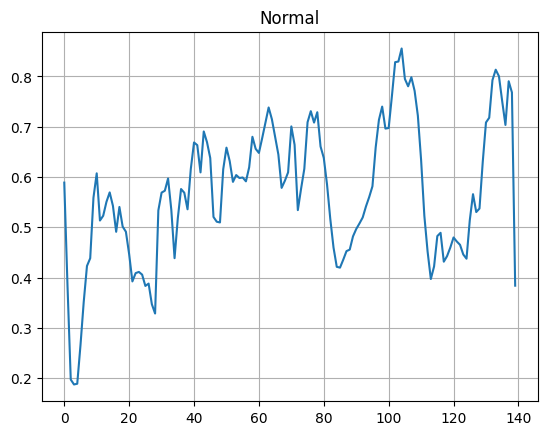

In [4]:
plt.grid()
plt.plot(np.arange(n_features), normal_train_data[0])
plt.title("Normal")
plt.show()

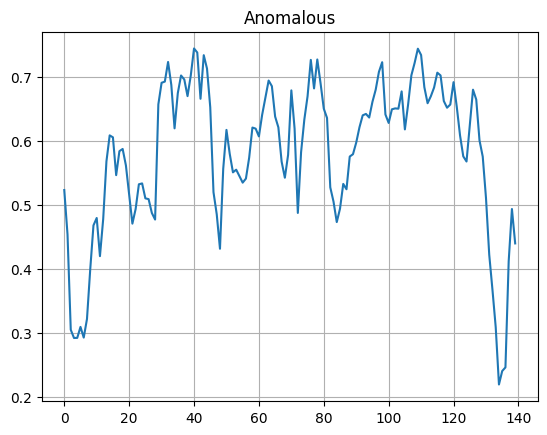

In [5]:
plt.grid()
plt.plot(np.arange(n_features), anomalous_train_data[0])
plt.title("Anomalous")
plt.show()

Now create a `Dataloader`  for each of the normal training, validation, and test set. It could be as simple as you want to be.

In [6]:
batch_size = 10

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

All good. Let now build a first simple fully connected autoencoder. You are free to use any number of hidden layers and neurons, and the type of activation functions.

You could for example use encoding with number of inputs as: 140->32->16->8 and symmetric decoding, e.g. 8->16->32->140.

Remember to be consistent in the last activation with the choice of the loss function later on.

In [7]:
class ECGAutoencoder(nn.Module):

  def __init__(self, n_features, z_dim):
    super(ECGAutoencoder, self).__init__()

    self.encoder = nn.Sequential(
            nn.Linear(140, 32),
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.ReLU(True),
            nn.Linear(16, z_dim),
            nn.ReLU(True))
    
    self.decoder = nn.Sequential(
            nn.Linear(z_dim, 16),
            nn.ReLU(True),
            nn.Linear(16, 32),
            nn.ReLU(True),
            nn.Linear(32, 140))

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

### Training

Let's write a helper function for our training process, that will take an autoencoder neural network model, both a training and a validation `DataLoader` and will loop over `n_epochs`.

Make sure to return the trained model, and arrays of the losses at each epoch to allow post-training plots.

In [8]:
def train_model(model, train_loader, val_loader, n_epochs):
  
  # set the optimizer 
  optimizer = optim.Adam(model.parameters(), lr=1e-3)

  # set the loss function 
  criterion = nn.MSELoss()

  # initialize train and val loss storage variables
  train_losses = []
  val_losses = []

  # initialize model training 
  model = model.train() 

  # for each epoch
  for epoch in range(n_epochs):

    # initialize train storage variable
    train_batch_losses = []

    # for the data in the training set 
    for data in train_loader: 

      # force it to be a 32 bit tensor and send to the gpu 
      data = torch.tensor(data, dtype=torch.float32, device=device)
      
      # my code block _
      optimizer.zero_grad() # zero the grad

      # get the output from the model and prop the loss 
      output = model(data)
      loss = criterion(output, data)
      loss.backward()

      # step forward 
      optimizer.step()

      # my code block ^
    
      train_batch_losses.append(loss.item())

    # do the same thing, minus back prop of error for the val set
    val_batch_losses = []
    model = model.eval()
    #with torch.no_grad():
    for data in val_loader:
      
      data = torch.tensor(data, dtype=torch.float32, device=device)       
      output = model(data)
      loss = criterion(output, data)
      val_batch_losses.append(loss.item())
    
    train_loss = np.mean(train_batch_losses)
    val_loss = np.mean(val_batch_losses)

    # update the training and validation loss 
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}: Losses Train = {train_loss:.4f} Valid = {val_loss:.4f}")

  # plot losses
  ax = plt.figure().gca()
  ax.plot(train_losses)
  ax.plot(val_losses)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'val'])
  plt.title('Loss monitoring')
  plt.show()

  # return trained model and loss arrays.
  return model.eval()

Now train an `ECGAutoencoder` with a latent dimension of 8, plot the loss history and save the model.

<ipython-input-8-44087d6e39a6>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32, device=device)
<ipython-input-8-44087d6e39a6>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32, device=device)


Epoch 10: Losses Train = 0.0039 Valid = 0.0044
Epoch 20: Losses Train = 0.0031 Valid = 0.0033
Epoch 30: Losses Train = 0.0024 Valid = 0.0026
Epoch 40: Losses Train = 0.0020 Valid = 0.0021
Epoch 50: Losses Train = 0.0018 Valid = 0.0019
Epoch 60: Losses Train = 0.0017 Valid = 0.0018
Epoch 70: Losses Train = 0.0017 Valid = 0.0017
Epoch 80: Losses Train = 0.0016 Valid = 0.0017
Epoch 90: Losses Train = 0.0016 Valid = 0.0017
Epoch 100: Losses Train = 0.0016 Valid = 0.0017
Epoch 110: Losses Train = 0.0016 Valid = 0.0017
Epoch 120: Losses Train = 0.0015 Valid = 0.0017
Epoch 130: Losses Train = 0.0014 Valid = 0.0016
Epoch 140: Losses Train = 0.0012 Valid = 0.0015
Epoch 150: Losses Train = 0.0011 Valid = 0.0013


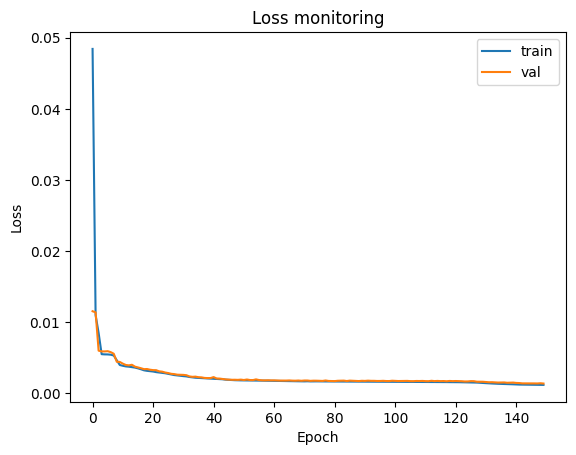

In [9]:
model = ECGAutoencoder(n_features, 8)
model = model.to(device)
model = train_model(model, train_loader, val_loader, n_epochs=150)

torch.save(model, 'ecg_autoencoder.pt')


#### Comments

Add a couple lines of comments on the training procedure. Did that, woop.


## Evaluating the outputs

The trained model can be used to reconstruct the ECGs. 
Let's plot some of the reconstructed ECG segments, both from the normal and anomalous.

Create a prediction function that takes a trained model and a dataset, and returns arrays of the predictions and the losses.

We will use these to plot the reconstruction and histograms of the losses

In [10]:
def plot_reconstruction(data, model, title, ax):
  recon, losses = predict(model, data)
  ax.plot(data, label='original')
  ax.plot(recon[0], label='reconstructed')
  #ax.plot(recon[0])
  #ax.set_title(f'{title}: loss = {np.around(losses[0], 3)}')
  ax.legend()

In [11]:
def predict(model, data):
  
  preds, losses = [], []
  criterion = nn.MSELoss()

  if len(np.shape(data)) > 1: 
    for _, x in enumerate(data):
      with torch.no_grad():
        model = model.to(device)
        model = model.eval()
        #  your code
        data = torch.tensor(x, dtype=torch.float32, device=device)
        output = model(data)
        output.to(device)
        loss = criterion(output, data)
        output = output.to(device='cpu')
        preds.append(output.data.numpy())
        losses.append(loss.item())
  else: 
    with torch.no_grad():
      model = model.to(device)
      model = model.eval()
      #  your code
      data = torch.tensor(data, dtype=torch.float32, device=device)
      output = model(data)
      loss = criterion(output, data)
      output = output.to(device='cpu')
      preds.append(output.numpy())
      losses.append(loss.item())

  # should return a tuple of an array of the predictions and an array the corresponding loss values
  return preds, losses

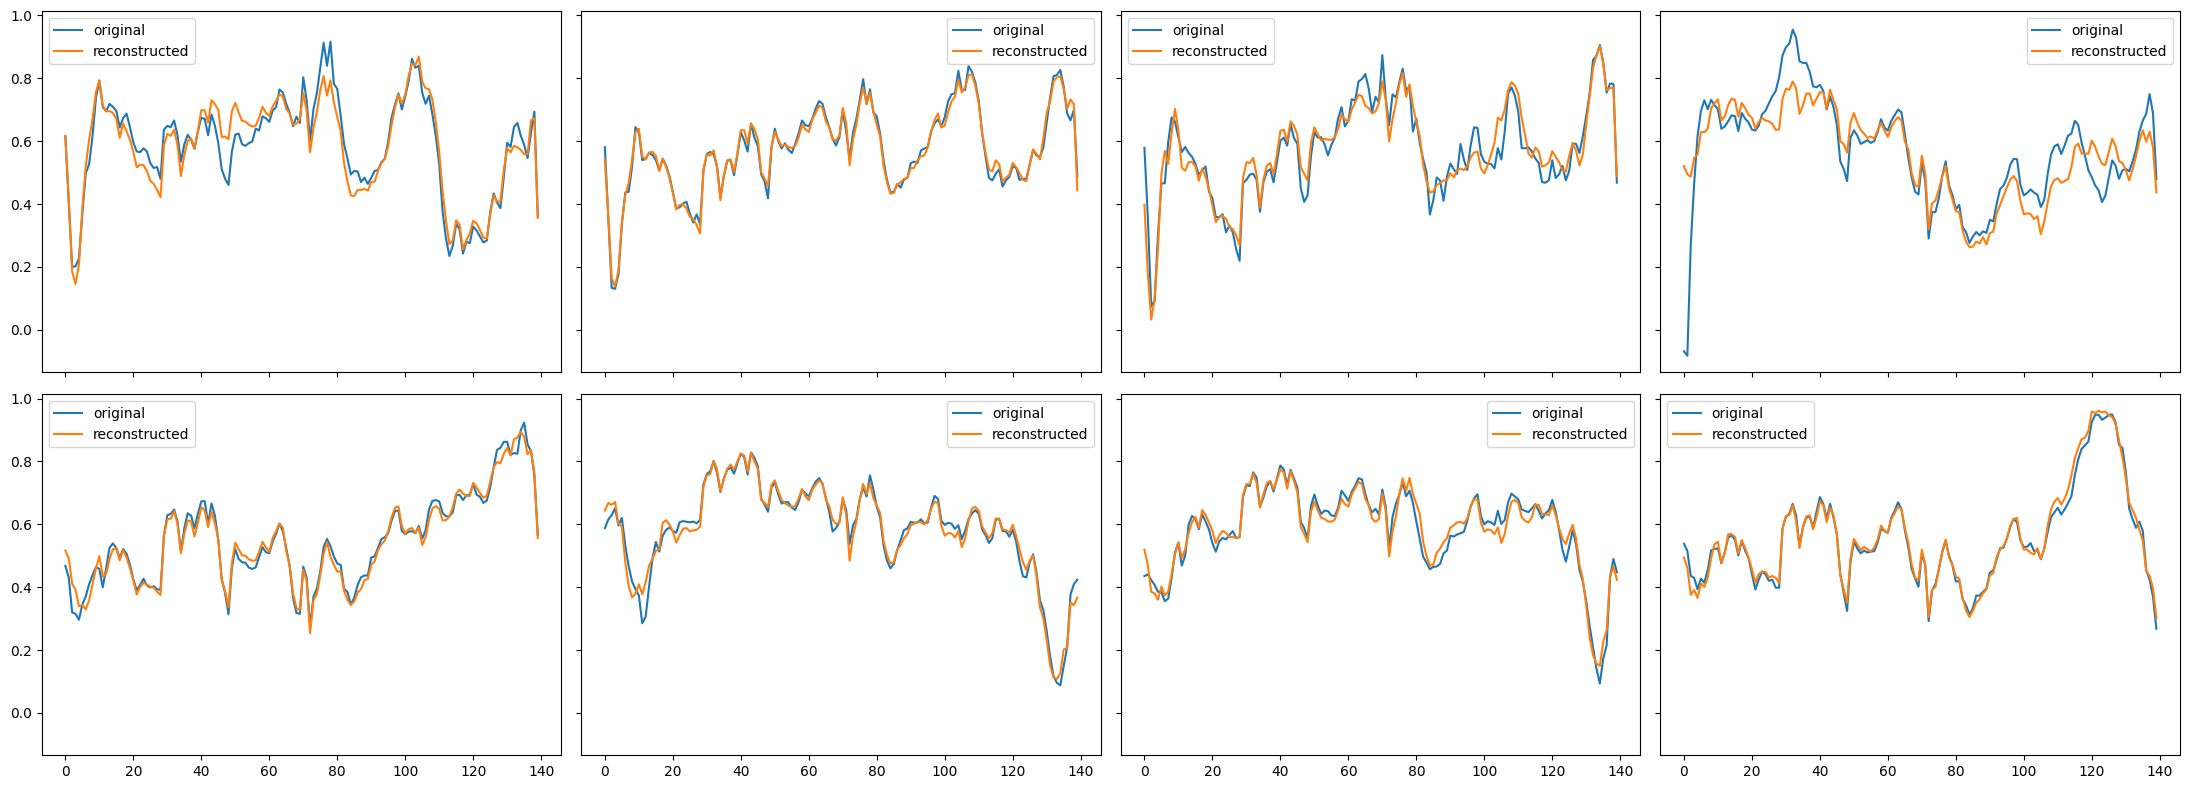

In [12]:
n_ex = 4
fig, axs = plt.subplots(nrows=2, ncols=n_ex, sharex=True, sharey=True, figsize=(22, 8))

for col, data in enumerate(normal_test_data[:n_ex]):
  plot_reconstruction(data, model, title='Normal', ax=axs[0, col])

for col, data in enumerate(anomalous_test_data[:n_ex]):
  plot_reconstruction(data, model, title='Anomalous', ax=axs[1, col])

fig.tight_layout()

### Convolutional autoencoder

Now copy the`ECGAutoencoder` network definition, and modify it with a Convolutional Autoencoder. You are fairly free to build your network, here is a proposal:

- `self.encoder`: two blocks, each consisting of a one-dimensional convolutional layer, a ReLU activation, and a one-dimentional Batch normalisation. You are free to choose kernel size, strides and padding. You can add 2 fully-connected layers, to produce a compressed latent space.

- `self.decoder`: the symmetric of the encoder, by using `ConvTranspose1D` instead to expand to larger layers.

In [22]:
class ECGConvAutoencoder(nn.Module):

  def __init__(self, n_features, z_dim):
    super(ECGConvAutoencoder, self).__init__()

    self.n_features = n_features
    self.z_dim = z_dim

    self.conv = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm1d(16),
        nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.BatchNorm1d(32)
    )

    self.lin = nn.Sequential(
        nn.Linear(n_features, 32),
        nn.ReLU(True),
        nn.Linear(32, z_dim),
        nn.ReLU(True)
        )
    
    self.dlin = nn.Sequential(
        nn.Linear(z_dim, 32), 
        nn.ReLU(True),
        nn.Linear(32, n_features),
        nn.ReLU(True)
    )

    self.dconv = nn.Sequential(
        nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=5, padding=2), 
        nn.ReLU(True), 
        nn.BatchNorm1d(16),
        nn.ConvTranspose1d(in_channels=16, out_channels=1, kernel_size=3, padding=1), 
        nn.ReLU(True)   
    )
    
  def encoder(self, x): 
    x = x.view(-1, 1, self.n_features)
    x = self.conv(x)
    x = self.lin(x)
    return x

  def decoder(self, x): 
    x = self.dlin(x)
    x = self.dconv(x)
    #x = x.view(-1, self.n_features)
    return x

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    if len(x.shape) == 1:
      decoded = decoded.view(self.n_features)
    return decoded

Let's train the new network

<ipython-input-8-44087d6e39a6>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32, device=device)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10, 140])) that is different to the input size (torch.Size([10, 1, 140])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8, 140])) that is different to the input size (torch.Size([8, 1, 140])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)

Epoch 10: Losses Train = 0.0113 Valid = 0.0121
Epoch 20: Losses Train = 0.0112 Valid = 0.0120
Epoch 30: Losses Train = 0.0112 Valid = 0.0118
Epoch 40: Losses Train = 0.0112 Valid = 0.0116
Epoch 50: Losses Train = 0.0111 Valid = 0.0116
Epoch 60: Losses Train = 0.0111 Valid = 0.0117
Epoch 70: Losses Train = 0.0111 Valid = 0.0116
Epoch 80: Losses Train = 0.0111 Valid = 0.0116
Epoch 90: Losses Train = 0.0110 Valid = 0.0116
Epoch 100: Losses Train = 0.0110 Valid = 0.0116
Epoch 110: Losses Train = 0.0110 Valid = 0.0115
Epoch 120: Losses Train = 0.0110 Valid = 0.0116
Epoch 130: Losses Train = 0.0110 Valid = 0.0117
Epoch 140: Losses Train = 0.0110 Valid = 0.0115
Epoch 150: Losses Train = 0.0110 Valid = 0.0116


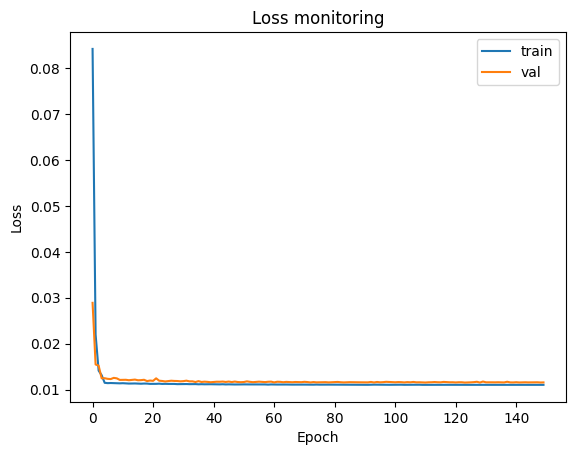

In [23]:
model = ECGConvAutoencoder(n_features, 8)
model = model.to(device)
model = train_model(model, train_loader, val_loader, n_epochs=150)

torch.save(model, 'ecg_convautoencoder.pt')

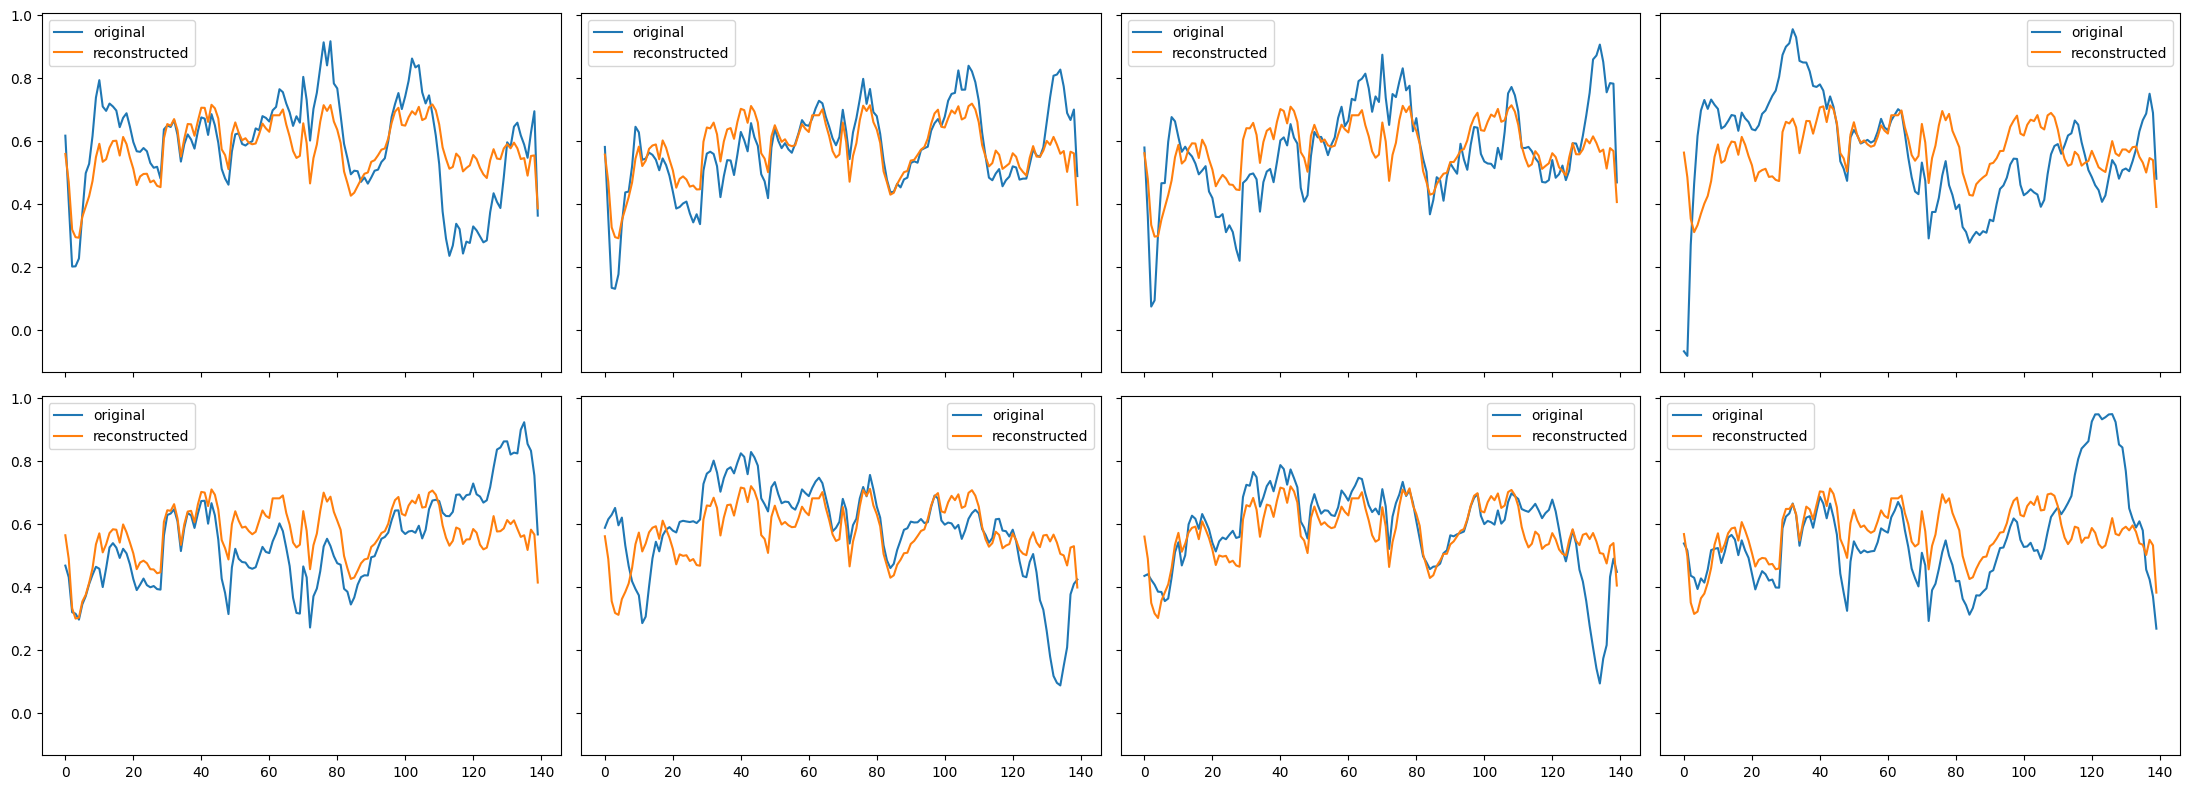

In [24]:
fig, axs = plt.subplots(nrows=2, ncols=n_ex, sharex=True, sharey=True, figsize=(22, 8))

for col, data in enumerate(normal_test_data[:n_ex]):
  plot_reconstruction(data, model, title='Normal', ax=axs[0, col])

for col, data in enumerate(anomalous_test_data[:n_ex]):
  plot_reconstruction(data, model, title='Anomalous', ax=axs[1, col])

fig.tight_layout()

## Anomalous samples detection

We can detect anomalies by evaluating whether the reconstruction metric (i.e. the loss for a sample) is greater than a given threshold.

For example, we can take the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.

Choose a threshold value that is one standard deviation above the mean of all the training sample losses.

Our function goes through each example in the dataset and records the predictions and losses. Let's get the losses and have a look at them.

The model can either the the convolutional or the fully-connected autoencoder. 

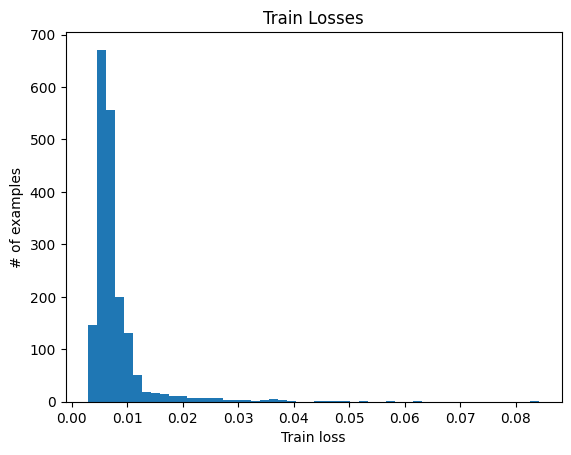

In [25]:
preds, train_losses = predict(model, normal_train_data)

plt.hist(train_losses, bins=50)
plt.xlabel("Train loss")
plt.ylabel("# of examples")
plt.title("Train Losses")
plt.show()

In [26]:
#Choose a threshold value that is one standard deviation above the mean of all the training sample losses.

mean = np.mean(train_losses)
std = np.std(train_losses)

threshold = mean + std

The problem is framed as a detection for a sample to be above or below the selected threshold.


Let's see how well the model performs on normal samples of the test set:


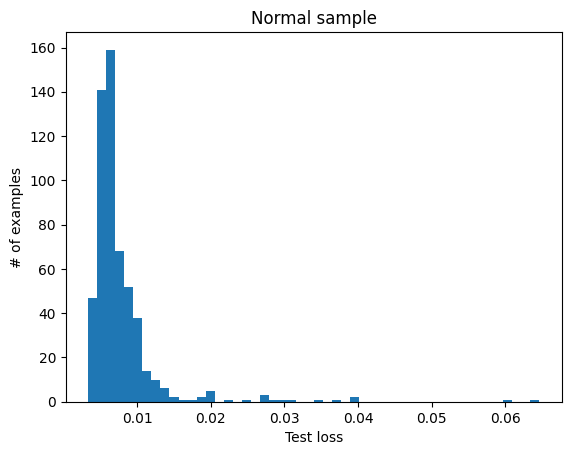

In [27]:
preds, losses = predict(model, normal_test_data)
plt.hist(losses, bins=50)
plt.xlabel("Test loss")
plt.ylabel("# of examples")
plt.title("Normal sample")
plt.show()

Do the same with the anomalous sample.

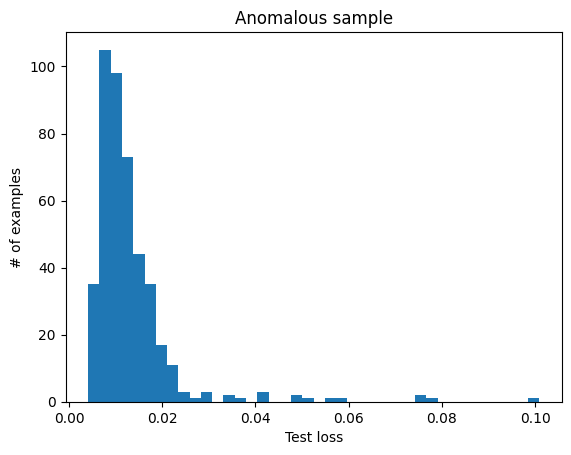

In [28]:
preds, lossesA = predict(model, anomalous_test_data)
plt.hist(lossesA, bins=40)
plt.xlabel("Test loss")
plt.ylabel("# of examples")
plt.title("Anomalous sample")
plt.show()

Finally, we can count the number of examples above and below the threshold similar to a classification model. Use standar metrics such as accuracy, precision and recall to evaluate your model.


In [29]:
def is_normal(model, data, threshold):
  # your code
  # returns true if loss is less than threshold
  preds, losses = predict(model, data)

  preds = []
  for loss in losses:
    if loss < threshold:
      preds.append(True)
    else:
      preds.append(False)
  return preds

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [30]:
preds = is_normal(model, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.664
Precision = 0.6339712918660287
Recall = 0.9464285714285714


I ran with the now commented like and the results were much lower. 
x = x.view(-1, self.n_features)

This fixes the tensorflow warning error but the results get so much worse, so I decided to leave it out.

## Extra

(Optional == Bonus points).
If time permits, you can build, train and evaluate other type or architectures
- an LSTM Autoencoder: it will take into account some time-dependence of the samples
- a VAE. 